# VXX Predictor using an adaBoost Model
Shorter period. Prediction no so consistent, eventhough get to x3+

In [83]:
# Import appropriate modules

import pandas as pd
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

import datetime
import numpy as np
import yfinance as yf
from datetime import datetime
from pandas.tseries.offsets import DateOffset
import hvplot
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from vix_functions import garch_fit_and_predict, correlation_filter, retrieve_yahoo_close, retrieve_yahoo_volume

from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

# CONTROL PANEL

In [145]:
# Key parameters of the model

# Min return to set up a positive signal
threshold= 0.00 

# Split of data
training_period_months = 24

# Adaboost parameters
adaboost_estimators = 5
learning_rate_adaboost = 1.5
max_depth=3


# Inclusion of the first 4 components lag1
#n: number of components to include
number_of_pca_lag_component_to_include = 4
num_pca_components = 40


# Definition of demo mode or development mode
demo_mode = False
parameter_tuning_mode = True
run_multiple_tuning_iterations = True

#Dates
start_date='2018-01-26'
today=datetime.today().date()
end_date=(today+DateOffset(days=-1)).date()
start_date_volatilities=(pd.to_datetime(start_date)+DateOffset(days=-364)).date()

print(f"start date: {start_date}, end date: {end_date}, start date volatilities: {start_date_volatilities}")

start date: 2018-01-26, end date: 2021-11-20, start date volatilities: 2017-01-27


# Generation of the Features Matrix X

### X1: close prices
#### 40 units: 
    * Close prices of international indexes of stocks and bonds, 
    * key stocks, 
    * currency exchange rates, 
    * commodities 

In [146]:
# Ticker List: VIX must be in first position
# ticker_list_ORIGINAL= ["^VIX", "spy", 'XLF', 'XLE',
#               'EURUSD=X', 'GBPUSD=X', 'AUDUSD=X', 'BRLUSD=X', "DX-Y.NYB","USDJPY=X", 
#               '^TNX', 'ZB=F', 'ZF=F', 'NQ=F','NKD=F',                                       
#               'LQD',
#               'AAPL', 'AMZN', 'GE','MU','MSFT', 'BMY', 'FDX', 'GS','PLD','NVDA',   
#               "tlt", "ief", 
#               "FXI", "EZU", "EEM", "EFA", 'FEZ', "^GDAXI", '^FTSE','^HSI','^FCHI',              #'^GSPC',
#               "gld", "slv", "CL=F"]

ticker_list= ["VXX","^VIX", "spy", 
               'GBPUSD=X', 'BRLUSD=X', "DX-Y.NYB","USDJPY=X", 
              '^TNX', 'ZF=F', 'NQ=F','NKD=F',                                       
              'LQD',
              'AAPL', 'AMZN','MU','MSFT', 'BMY', 'PLD', 
              "FXI", 'FEZ', '^FTSE','^FCHI','^GSPC',
              "gld", "slv", 
              "ES=F","QM=F", "BIO=F"
             ]



    
# Some of the less familiar tickers are listed below
# CAC 40 (^FCHI)
# Yen Denominated TOPIX Futures,D (TPY=F)
# FTSE 100 (^FTSE)
# SPDR EURO STOXX 50 ETF (FEZ)
# DAX PERFORMANCE-INDEX (^GDAXI)
# S&P500 Index (^GSPC)
# HANG SENG INDEX (^HSI)
# 13 Week Treasury Bill (^IRX) --eliminate
# Nikkei/USD Futures,Dec-2021 (NKD=F)
# iShares iBoxx $ Investment Grade Corporate Bond ETF (LQD)
# Nasdaq 100 Dec 21 (NQ=F)
# NVIDIA Corporation (NVDA)
# Euro spot  'EURUSD'
# American Funds U.S. Government Securities Fund Class C (UGSCX) - 2001
# Micron Technology, Inc. (MU)
# Microsoft Corporation (MSFT)
# Bristol-Myers Squibb Company (BMY)
# FEDEX CORP (FDX)
# The Goldman Sachs Group, Inc. (GS)
# Prologis, Inc. (PLD)
# Treasury Yield 10 Years (^TNX) -- 1985
# Energy Select Sector SPDR Fund (XLE)
# Financial Select Sector SPDR Fund (XLF)
# U.S. Treasury Bond Futures,Dec- (ZB=F) - 2000
# Five-Year US Treasury Note Futu (ZF=F) - 2000
# E-Mini S&P500 (ES=F)
# E-Mini oil (QM=F)
# E-MinI Nasdaq (BIO=F)
print(f"Current number of tickers: {len(ticker_list)}")


Current number of tickers: 28


In [147]:
# X1: Upload of data using API
def retrieve_close(close_prices_dict, ticker_list):
    """
    This function retrieves close prices from Yahoo Finance
    
    Arg:
    close_prices_dict: empty dictionary to be filled with the close prices
    ticker_list: a list of tickers of the yahoo close prices to be retrieve
    
    Return:
    A dictionary with close prices
    """
    
    
    for ticker in ticker_list:
        close_price = retrieve_yahoo_close(ticker, start_date=start_date, end_date=end_date)
        close_prices_dict[ticker] = close_price
    return close_prices_dict


if demo_mode == True:
    close_prices_df = pd.read_csv("adaboost_close_prices.csv", index_col="Date", parse_dates=True, infer_datetime_format=True)
else:
    close_prices_dict = {}
    close_prices_dict = retrieve_close(close_prices_dict, ticker_list)
    close_prices_df_raw= pd.DataFrame(close_prices_dict)
    close_prices_df_raw.to_csv("adaboost_close_prices.csv", index=True)
print("Completed retrieve of close prices")

Processing Close VXX
Processing Close ^VIX
Processing Close spy
Processing Close GBPUSD=X
Processing Close BRLUSD=X
Processing Close DX-Y.NYB
Processing Close USDJPY=X
Processing Close ^TNX
Processing Close ZF=F
Processing Close NQ=F
Processing Close NKD=F
Processing Close LQD
Processing Close AAPL
Processing Close AMZN
Processing Close MU
Processing Close MSFT
Processing Close BMY
Processing Close PLD
Processing Close FXI
Processing Close FEZ
Processing Close ^FTSE
Processing Close ^FCHI
Processing Close ^GSPC
Processing Close gld
Processing Close slv
Processing Close ES=F
Processing Close QM=F
Processing Close BIO=F
Completed retrieve of close prices


In [148]:
# X1 Fill of missing values
close_prices_df=close_prices_df_raw.ffill(axis='rows')
close_prices_df=close_prices_df_raw.bfill(axis='rows')

#RENAME COLUMN FROM UVXY TO VIXM SO WE DON'T NEED TO CHANGE THE REST OF THE PROGRAM
close_prices_df=close_prices_df.rename(columns={'VXX':'VIXM'})

# Apply correlation filter to keep just series with some minimum level of correlation of 0.2
close_prices_component_df = correlation_filter(close_prices_df, min_corr=0.20, key_column='VIXM', eliminate_first_column=True)

# First columns is not given back, so we take opportunity to rename them
X1=close_prices_component_df

vixm=close_prices_df['VIXM']
vixm_ret=close_prices_df['VIXM'].pct_change()

#vixm=close_prices_df['VIXM']
#vixm_ret=close_prices_df['VIXM'].pct_change()
## #VIXM=pd.DataFrame([vixm, vixm_ret]).T      
## #VIXM.columns=['VIXM','VIXM_ret'

vixm=pd.DataFrame([vixm]).T
vixm.columns=['VIXM']

vixm_ret=pd.DataFrame([vixm_ret]).T
vixm_ret.columns=['VIXM_ret']



X1_no_suffix=pd.concat([vixm,close_prices_component_df], axis=1)

X1=X1_no_suffix.add_suffix("_close")

print("Completed inclusion of close prices")
X1.head()

Completed inclusion of close prices


,VIXM_close,^VIX_close,spy_close,GBPUSD=X_close,BRLUSD=X_close,DX-Y.NYB_close,^TNX_close,ZF=F_close,NQ=F_close,NKD=F_close,...,PLD_close,FXI_close,FEZ_close,^FCHI_close,^GSPC_close,gld_close,slv_close,ES=F_close,QM=F_close,BIO=F_close
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-26,110.639999,11.08,268.326660,1.415027,0.317773,89.070000,2.662,114.968750,7030.25,23745.0,...,58.391167,49.872997,40.191101,5529.149902,2872.870117,128.070007,16.410000,2874.50,66.139999,3710.699951
2018-01-29,118.320000,13.84,266.547668,1.414927,0.317360,89.309998,2.699,114.875000,6992.50,23555.0,...,57.484322,48.810890,39.854740,5521.589844,2853.530029,127.349998,16.209999,2853.50,65.559998,3728.199951
2018-01-30,122.199997,14.79,263.813629,1.407658,0.317098,89.190002,2.726,114.835938,6941.50,23215.0,...,57.039978,48.007381,39.518379,5473.779785,2822.429932,126.800003,16.150000,2824.50,64.500000,3656.899902
2018-01-31,122.599998,13.54,263.944733,1.415588,0.314515,89.129997,2.720,114.710938,6962.50,23285.0,...,59.044086,48.644650,39.582020,5481.930176,2823.810059,127.650002,16.350000,2825.75,64.730003,3590.100098
2018-02-01,116.428001,13.47,263.645111,1.420051,0.314001,88.669998,2.773,114.546875,6898.50,23305.0,...,57.783585,47.942734,39.600197,5454.549805,2821.979980,128.070007,16.250000,2822.50,65.800003,3584.500000


In [149]:
#close_prices_df
#X1

In [150]:
# Presentation graphs of the SPY and the VIX

presentation_graph=pd.concat([X1['spy_close'], 2.5*X1['VIXM_close']],axis=1).hvplot(
        title='VIXM and S&P (Scale adjusted)',
        width=1000
)
presentation_graph

graph1=X1['spy_close'].hvplot(
                title= "SPY: iShares S&P 500 ETF Close Price",
                ylabel= 'Close Price [$]'
) 

graph2=X1['VIXM_close'].hvplot(
                color ='red',
                title ='VIXM close price',
                ylabel= '[%]'

)
display(graph1)
graph2 



:Curve   [Date]   (spy_close)

:Curve   [Date]   (VIXM_close)

### X2: returns

In [151]:
# Inclusion of security returns X2
# Include returns that are correlated more than 0.20 with the VIXM return

security_returns_df= close_prices_df.pct_change()
security_returns_component_df = correlation_filter(
                                        security_returns_df, 
                                        min_corr=0.20, 
                                        key_column='VIXM', 
                                        eliminate_first_column=False
)

X2_no_suffix=security_returns_component_df

X2=X2_no_suffix.add_suffix("_returns")

print("Completed inclusion of returns")

X2

Completed inclusion of returns


,VIXM_returns,^VIX_returns,spy_returns,^TNX_returns,ZF=F_returns,NQ=F_returns,NKD=F_returns,LQD_returns,AAPL_returns,AMZN_returns,...,BMY_returns,PLD_returns,FXI_returns,FEZ_returns,^FTSE_returns,^FCHI_returns,^GSPC_returns,slv_returns,ES=F_returns,BIO=F_returns
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-29,0.069414,0.249097,-0.006630,0.013899,-0.000815,-0.005370,-0.008002,-0.002655,-0.020699,0.011148,...,0.002801,-0.015531,-0.021296,-0.008369,0.000783,-0.001367,-0.006732,-0.012188,-0.007306,0.004716
2018-01-30,0.032792,0.068642,-0.010257,0.010004,-0.000340,-0.007294,-0.014434,-0.003410,-0.005894,0.014206,...,-0.007295,-0.007730,-0.016462,-0.008440,-0.010884,-0.008659,-0.010899,-0.003701,-0.010163,-0.019125
2018-01-31,0.003273,-0.084517,0.000497,-0.002201,-0.001089,0.003025,0.003015,0.002087,0.002755,0.009090,...,-0.021263,0.035135,0.013274,0.001610,-0.007169,0.001489,0.000489,0.012384,0.000443,-0.018267
2018-02-01,-0.050343,-0.005170,-0.001135,0.019485,-0.001430,-0.009192,0.000859,-0.004418,0.002090,-0.041967,...,0.003195,-0.021348,-0.014429,0.000459,-0.005734,-0.004995,-0.000648,-0.006116,-0.001150,-0.001560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-15,-0.011788,0.012277,0.000342,0.025917,-0.000643,-0.000309,0.000336,-0.007595,0.000067,0.005824,...,0.003197,0.009341,-0.007484,-0.005151,0.000544,0.005250,-0.000011,-0.007686,0.000160,-0.004850
2021-11-16,0.003479,-0.007277,0.003958,0.006778,-0.000515,0.006981,0.003531,-0.001667,0.006667,-0.001405,...,-0.008722,-0.004860,0.012649,0.000000,-0.003387,0.003363,0.003865,-0.012048,0.003633,0.000933
2021-11-17,0.016345,0.045205,-0.002429,-0.018360,0.001095,0.000659,-0.009048,0.004023,0.016490,0.002344,...,0.005753,0.006088,-0.011290,0.000207,-0.004886,0.000594,-0.002602,0.009146,-0.002076,-0.000725


In [152]:
#security_returns_component_df.head()
X2

,VIXM_returns,^VIX_returns,spy_returns,^TNX_returns,ZF=F_returns,NQ=F_returns,NKD=F_returns,LQD_returns,AAPL_returns,AMZN_returns,...,BMY_returns,PLD_returns,FXI_returns,FEZ_returns,^FTSE_returns,^FCHI_returns,^GSPC_returns,slv_returns,ES=F_returns,BIO=F_returns
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-29,0.069414,0.249097,-0.006630,0.013899,-0.000815,-0.005370,-0.008002,-0.002655,-0.020699,0.011148,...,0.002801,-0.015531,-0.021296,-0.008369,0.000783,-0.001367,-0.006732,-0.012188,-0.007306,0.004716
2018-01-30,0.032792,0.068642,-0.010257,0.010004,-0.000340,-0.007294,-0.014434,-0.003410,-0.005894,0.014206,...,-0.007295,-0.007730,-0.016462,-0.008440,-0.010884,-0.008659,-0.010899,-0.003701,-0.010163,-0.019125
2018-01-31,0.003273,-0.084517,0.000497,-0.002201,-0.001089,0.003025,0.003015,0.002087,0.002755,0.009090,...,-0.021263,0.035135,0.013274,0.001610,-0.007169,0.001489,0.000489,0.012384,0.000443,-0.018267
2018-02-01,-0.050343,-0.005170,-0.001135,0.019485,-0.001430,-0.009192,0.000859,-0.004418,0.002090,-0.041967,...,0.003195,-0.021348,-0.014429,0.000459,-0.005734,-0.004995,-0.000648,-0.006116,-0.001150,-0.001560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-15,-0.011788,0.012277,0.000342,0.025917,-0.000643,-0.000309,0.000336,-0.007595,0.000067,0.005824,...,0.003197,0.009341,-0.007484,-0.005151,0.000544,0.005250,-0.000011,-0.007686,0.000160,-0.004850
2021-11-16,0.003479,-0.007277,0.003958,0.006778,-0.000515,0.006981,0.003531,-0.001667,0.006667,-0.001405,...,-0.008722,-0.004860,0.012649,0.000000,-0.003387,0.003363,0.003865,-0.012048,0.003633,0.000933
2021-11-17,0.016345,0.045205,-0.002429,-0.018360,0.001095,0.000659,-0.009048,0.004023,0.016490,0.002344,...,0.005753,0.006088,-0.011290,0.000207,-0.004886,0.000594,-0.002602,0.009146,-0.002076,-0.000725


### X3: volume

In [153]:
# inclusion of security volume X3
volume_list = ticker_list[0:len(ticker_list)]

def retrieve_volume(volume_dict, volume_list):
    """
    This function retrieve volume trades from a list of tickers
    
    Args:
    volume_dict: an initial dictionary to populate
    volume_list: the list of tickers for which to retrieve the volume
    
    
    Return:
    The original dictionary filled with the volume of the list of tickers
    """
    for ticker in volume_list:        
        volume = retrieve_yahoo_volume(ticker, start_date=start_date, end_date=end_date)
        volume_dict[ticker] = volume
    return volume_dict

if demo_mode == True:
    volume_df = pd.read_csv("adaboost_volume.csv", index_col="Date", parse_dates=True, infer_datetime_format=True)
else:
    volume_dict = {}
    volume_dict = retrieve_volume(volume_dict, volume_list)
    volume_df= pd.DataFrame(volume_dict)
    volume_df.to_csv("adaboost_volume.csv", index=True)
print("Completed retrieve of volume")

volume_df_with_vixm=pd.concat([vixm_ret, volume_df], axis=1)
#print(volume_df_with_vixm.corr())

volume_component_df = correlation_filter(volume_df_with_vixm, min_corr=0.14, key_column='VIXM_ret', eliminate_first_column=True )
X3_no_suffix=volume_component_df

X3=X3_no_suffix.add_suffix("_volume")

Processing Volume VXX
Processing Volume ^VIX
Processing Volume spy
Processing Volume GBPUSD=X
Processing Volume BRLUSD=X
Processing Volume DX-Y.NYB
Processing Volume USDJPY=X
Processing Volume ^TNX
Processing Volume ZF=F
Processing Volume NQ=F
Processing Volume NKD=F
Processing Volume LQD
Processing Volume AAPL
Processing Volume AMZN
Processing Volume MU
Processing Volume MSFT
Processing Volume BMY
Processing Volume PLD
Processing Volume FXI
Processing Volume FEZ
Processing Volume ^FTSE
Processing Volume ^FCHI
Processing Volume ^GSPC
Processing Volume gld
Processing Volume slv
Processing Volume ES=F
Processing Volume QM=F
Processing Volume BIO=F
Completed retrieve of volume


In [154]:
#volume_component_df
#X3
#volume_df_with_vixm

######## ADJUSTMENT FOR VIXM NAME ##########
#RENAME COLUMN FROM UVXY TO VIXM SO WE DON'T NEED TO CHANGE THE REST OF THE PROGRAM
security_returns_df=security_returns_df.rename(columns={'UVXY':'VIXM'})

ticker_list= ["VIXM","^VIX", "spy", 
               'GBPUSD=X', 'BRLUSD=X', "DX-Y.NYB","USDJPY=X", 
              '^TNX', 'ZF=F', 'NQ=F','NKD=F',                                       
              'LQD',
              'AAPL', 'AMZN','MU','MSFT', 'BMY', 'PLD', 
              "FXI", 'FEZ', '^FTSE','^FCHI','^GSPC',
              "gld", "slv", 
              "ES=F","QM=F", "BIO=F"
             ]


### X4: GARCH Models
    * GJR-GARCH Model conditional volatility
    * Model a response to shocks
    * Allow an asymmetryc t-student distribution 

In [155]:
# Inclusion of GARCH series X4
garch_series_df=pd.DataFrame()

not_to_include=[]#['BIO=F']


for ticker in ticker_list:
    
        if ticker in not_to_include:
            continue
    
        if demo_mode == True:
            print_series = False
        else:
            print_series = True
        garch_series_df[ticker]=garch_fit_and_predict(security_returns_df[ticker], ticker, horizon=1, p=1, q=1, o=1, print_series_name=print_series)
            
        
X4_no_suffix=garch_series_df
X4=X4_no_suffix.add_suffix("_garch")

if demo_mode == False:
    X4

print('GARCH Process fit and predictions completed')


Processing series: VIXM.....
Processing series: ^VIX.....
Processing series: spy.....
Processing series: GBPUSD=X.....
Processing series: BRLUSD=X.....
Processing series: DX-Y.NYB.....
Processing series: USDJPY=X.....
Processing series: ^TNX.....
Processing series: ZF=F.....
Processing series: NQ=F.....
Processing series: NKD=F.....
Processing series: LQD.....
Processing series: AAPL.....
Processing series: AMZN.....
Processing series: MU.....
Processing series: MSFT.....
Processing series: BMY.....
Processing series: PLD.....
Processing series: FXI.....
Processing series: FEZ.....
Processing series: ^FTSE.....
Processing series: ^FCHI.....
Processing series: ^GSPC.....
Processing series: gld.....
Processing series: slv.....
Processing series: ES=F.....
Processing series: QM=F.....
Processing series: BIO=F.....
GARCH Process fit and predictions completed


In [156]:
garch_series_df
#X4

,VIXM,^VIX,spy,GBPUSD=X,BRLUSD=X,DX-Y.NYB,USDJPY=X,^TNX,ZF=F,NQ=F,...,FXI,FEZ,^FTSE,^FCHI,^GSPC,gld,slv,ES=F,QM=F,BIO=F
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-29,0.920992,2.595697,1.481210,0.525557,0.771869,0.391010,0.614207,0.143356,1.479623,1.743093,...,2.095744,1.515462,0.992971,1.066069,1.459470,0.688829,1.215939,1.644449,0.174378,1.456766
2018-01-30,0.828384,2.274547,1.476289,0.528054,0.762408,0.380245,0.572078,0.140625,1.407898,1.670042,...,2.056015,1.469589,1.021061,1.094900,1.472230,0.680257,1.193865,1.602707,0.193067,1.883933
2018-01-31,0.730452,1.976879,1.335776,0.529441,0.774898,0.368718,0.536878,0.137205,1.367652,1.555435,...,1.939741,1.374511,1.018583,1.035307,1.334808,0.690697,1.220769,1.464993,0.188105,2.082798
2018-02-01,0.647554,1.724651,1.215061,0.514079,0.765695,0.385637,0.508037,0.137241,1.351615,1.532506,...,1.900194,1.286858,1.008341,1.012143,1.214489,0.681888,1.201992,1.343966,0.188347,1.724475
2018-02-02,0.902117,2.108194,1.688867,0.511053,0.759343,0.389746,0.477475,0.141357,1.321315,1.780171,...,1.887216,1.691196,1.001438,1.245083,1.652770,0.713652,1.355732,1.750353,0.186718,1.893118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-15,0.319050,0.642129,0.585816,0.570908,0.983565,0.340768,0.353320,0.304410,2.230328,0.920914,...,1.459264,0.823295,0.599005,0.494945,0.594904,0.832297,1.526512,0.586263,0.221731,1.078826
2021-11-16,0.313347,0.628862,0.558932,0.540356,0.968757,0.346145,0.343027,0.295415,2.098442,0.881761,...,1.416247,0.784572,0.601093,0.487988,0.568040,0.823968,1.506551,0.564544,0.209739,0.892078
2021-11-17,0.321638,0.653928,0.560298,0.516300,0.972400,0.337447,0.356788,0.292131,2.021874,0.846672,...,1.423889,0.749736,0.611835,0.481824,0.570434,0.841629,1.492058,0.559919,0.250744,0.739296


### X5: Return squared


In [157]:
# Inclusion of return squares in X5

returns_squared_df= security_returns_df**2
returns_squared_and_vixm_ret_df=pd.concat([vixm_ret,returns_squared_df], axis=1)
returns_squared_and_vixm_ret_df
returns_squared_component_df = correlation_filter(returns_squared_and_vixm_ret_df, min_corr=0.20, key_column='VIXM', eliminate_first_column=True)

X5_no_suffix_df=returns_squared_component_df
X5=X5_no_suffix_df.add_suffix("_return_squared")

if demo_mode == False:
    X5
print("Completed inclusion of return squared")
X5.head()

Completed inclusion of return squared


,VIXM_return_squared,^VIX_return_squared,spy_return_squared,USDJPY=X_return_squared,^TNX_return_squared,ZF=F_return_squared,NQ=F_return_squared,NKD=F_return_squared,LQD_return_squared,AAPL_return_squared,...,BMY_return_squared,PLD_return_squared,FXI_return_squared,FEZ_return_squared,^FTSE_return_squared,^FCHI_return_squared,^GSPC_return_squared,slv_return_squared,ES=F_return_squared,BIO=F_return_squared
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-29,0.004818,0.062050,4.395621e-05,0.000094,0.000193,6.649407e-07,0.000029,6.402696e-05,0.000007,0.000428,...,0.000008,0.000241,0.000454,7.004083e-05,6.126628e-07,0.000002,4.531948e-05,0.000149,5.337206e-05,0.000022
2018-01-30,0.001075,0.004712,1.052107e-04,0.000007,0.000100,1.156296e-07,0.000053,2.083491e-04,0.000012,0.000035,...,0.000053,0.000060,0.000271,7.122806e-05,1.184711e-04,0.000075,1.187842e-04,0.000014,1.032857e-04,0.000366
2018-01-31,0.000011,0.007143,2.469643e-07,0.000003,0.000005,1.184853e-06,0.000009,9.091985e-06,0.000004,0.000008,...,0.000452,0.001234,0.000176,2.593404e-06,5.139745e-05,0.000002,2.391067e-07,0.000153,1.958560e-07,0.000334
2018-02-01,0.002534,0.000027,1.288606e-06,0.000019,0.000380,2.045545e-06,0.000084,7.377471e-07,0.000020,0.000004,...,0.000010,0.000456,0.000208,2.108871e-07,3.288261e-05,0.000025,4.200184e-07,0.000037,1.322815e-06,0.000002


In [158]:
#returns_squared_df
#X5

### X6: Google Trends

In [159]:
# # Upload of Google Tremds -- X6
# keywords=['banking', "consumer", "depression", "gdp", "inflation",
#           'unemployment', 'liquidity','cci', 'vix_word']
# google_trends_df=pd.DataFrame()

# for keyword in keywords:
#     file_path=f"./Resources/Google_trends/{keyword}.csv"
#     if demo_mode == False:
#         print(file_path)
#     trend=pd.read_csv(Path(file_path),
#                       index_col= 'Daily', 
#                       parse_dates= True,
#                       infer_datetime_format=True
#                      )
#     #print(trend)
#     google_trends_df=pd.concat([google_trends_df, trend], axis=1)
#     #print(google_trends_df)

# if demo_mode == False:
#     google_trends_df
# print('Google Trends load completed')

In [160]:
# # Working on preparing Google-trends data

# # Unifying google dates with VIX
# minimum_date=vix.index.min()
# maximum_date=vix.index.max()

# google_trends_df=google_trends_df.loc[minimum_date:maximum_date,:]
# #print(google_trends_df.iloc[0,:])

# vix_google_trends_df=pd.concat([vix, google_trends_df], axis=1)
# vix_google_trends_df.isna().sum()

# #print(vix_google_trends_df.head())

# #vix_google_trends_df=vix_google_trends_df.fillna(0)
# #vix_google_trends_df
# #vix_google_trends_df.loc[vix_google_trends_df['^VIX'].isna(),['^VIX','Banking: (United States)']]

# # We will drop Saturday Sunday, but we would like to average Fri-Sat-Sun and reset the value of Friday
# vix_google_trends_df=vix_google_trends_df.dropna()
# google_trends_df=vix_google_trends_df.iloc[:,1:]
# #google_trends_df.isna().sum()

In [161]:
# # Filtering by correlation X6

# google_trends_component_df = correlation_filter(
#                                 vix_google_trends_df, 
#                                 min_corr=0.05, 
#                                 key_column='^VIX', 
#                                 eliminate_first_column=True)

# X6=google_trends_component_df

# # We will interpolate so we can fill the missing data only on Google Trends
# pro_interpolation_of_X6=pd.concat([vix, X6], axis=1)
# pro_interpolation_of_X6=pro_interpolation_of_X6.interpolate(method="polynomial", order=2, axis=0)
# pro_interpolation_of_X6
# X6_no_suffix_df = pro_interpolation_of_X6.iloc[:,1:]
# X6 = X6_no_suffix_df.add_suffix("_google_trends")

# if demo_mode == False:
#     X6.shape
# print('Google Trends process inclusion completed')

### X7: Economic and Financial Series

In [162]:
# #Economic Series
# # Upload of csv files -- X7
# keywords=['JobClaimsWeeklySeries', 'vix_put_call_ratio']
# economic_series_df=pd.DataFrame()

# for keyword in keywords:
#     file_path=f"./Resources/Economic_and_financial_Series/{keyword}.csv"
#     if demo_mode == False:
#         print(file_path)
#     new_series=pd.read_csv(Path(file_path),
#                       index_col= 'DATE', 
#                       parse_dates= True,
#                       infer_datetime_format=True
#                      )
#     new_series=new_series.iloc[:,0]
#     if keyword=='JobClaimsWeeklySeries':
#         new_series=new_series.shift(-1, freq='D')
#     if demo_mode == False:
#         print(new_series)
#     # Adjustment due to weekend data. We are going to assign data on the weekends to Friday, since are going to be 
#     # consider for the the prediction of Monday
#     economic_series_df=pd.concat([economic_series_df, new_series], axis=1)
#     #print(economic_series_df.tail())

# economic_series_df
# economic_series_change_df = economic_series_df.pct_change().add_suffix('_change')

# if demo_mode == False:
#     economic_series_df.loc[:,:].tail(20)

In [163]:
# # Preparation of economic variables

# # Changes of columns that are on a weekend - concat with vix to add week days
# vix_economic= pd.concat([vix,economic_series_df,economic_series_change_df ],axis=1)
# vix_economic['VIX Put/Call Ratio']= vix_economic['VIX Put/Call Ratio'].fillna(0)

# # Applying interpolation to appropiate columns. Levels: interpolation, changes: zeros
# vix_economic.loc[:,economic_series_df.columns]=vix_economic.loc[:,economic_series_df.columns].interpolate(method="polynomial", order=2, axis=0)
# vix_economic.loc[:,economic_series_change_df.columns]=vix_economic.loc[:,economic_series_change_df.columns].fillna(0)

# #print(vix_economic)

# #Filtering for available dates
# economic_series_ready_df = vix_economic.loc[minimum_date:maximum_date,:]
# economic_series_ready_df = economic_series_ready_df.iloc[:,1:]

# X7_no_suffix_df=economic_series_ready_df
# X7=X7_no_suffix_df.add_suffix("_macroeconomics")

# print("Completed inclusion of economic variables")

### X8: volatility of the SPY in several rolling windows

In [164]:
# SPY volatility on varios tracks X8

#if demo_mode == True:
#    close_price_spy_df = pd.read_csv("adaboost_spy_data.csv", index_col="Date", parse_dates=True, infer_datetime_format=True)
    
# Retrieve yahoo close prices for spy, so to be able to calculate rolling volatilities
#else:
close_price_spy_df = retrieve_yahoo_close('spy', start_date= start_date_volatilities, end_date=end_date)  #MATCH DATE ABOVE
close_price_spy_df.to_csv("adaboost_spy_data.csv", index=True)
    
# Calculate returns
spy_returns_df=close_price_spy_df.pct_change()

#Initialize dataframe for volatility
spy_volatility=pd.DataFrame()

# Define rolling windows to create
windows_for_lag=[10,20,30,60,90,120,180,200,260]

# Loop to create the volatilities
for window_size in windows_for_lag:
    column_name=f"{window_size}_spy_rolling_volatility"
    spy_volatility[column_name] = spy_returns_df.rolling(window=window_size).std()

# Concatenate to vix to uniform index
X8=pd.concat([vixm, spy_volatility], axis=1)

# Define min and max values for the window
X8=X8.loc[start_date:end_date,:]        ## CORRECT MAXIMUM DATE
    
# Fill missing data
X8=X8.ffill()
X8=X8.iloc[:,1:]

# Setting for demo
if demo_mode == False:
    X8.shape
print("Inclusion of rolling volatilities completed")
X8.tail()

Processing Close spy
Inclusion of rolling volatilities completed


,10_spy_rolling_volatility,20_spy_rolling_volatility,30_spy_rolling_volatility,60_spy_rolling_volatility,90_spy_rolling_volatility,120_spy_rolling_volatility,180_spy_rolling_volatility,200_spy_rolling_volatility,260_spy_rolling_volatility
Date,,,,,,,,,
2021-11-15,0.004663,0.004320,0.005334,0.007071,0.006787,0.006465,0.007137,0.007422,0.007814
2021-11-16,0.004658,0.004147,0.005148,0.007007,0.006789,0.006471,0.007058,0.007368,0.007705
2021-11-17,0.004520,0.004237,0.005223,0.007019,0.006783,0.006478,0.006989,0.007372,0.007625
2021-11-18,0.004409,0.004250,0.005096,0.007025,0.006788,0.006479,0.006872,0.007338,0.007625
2021-11-19,0.004343,0.004279,0.005095,0.006978,0.006778,0.006484,0.006860,0.007337,0.007595


In [165]:
#spy_volatility
X8

,10_spy_rolling_volatility,20_spy_rolling_volatility,30_spy_rolling_volatility,60_spy_rolling_volatility,90_spy_rolling_volatility,120_spy_rolling_volatility,180_spy_rolling_volatility,200_spy_rolling_volatility,260_spy_rolling_volatility
Date,,,,,,,,,
2018-01-26,0.005098,0.004385,0.004389,0.004082,0.003749,0.004320,0.004372,0.004381,NaN
2018-01-29,0.005929,0.004931,0.004678,0.004229,0.003848,0.004381,0.004404,0.004398,NaN
2018-01-30,0.006979,0.005575,0.005089,0.004506,0.004042,0.004492,0.004479,0.004438,NaN
2018-01-31,0.006420,0.005495,0.004960,0.004506,0.004019,0.004491,0.004467,0.004403,NaN
2018-02-01,0.006399,0.005468,0.004916,0.004513,0.004026,0.004271,0.004467,0.004397,NaN
...,...,...,...,...,...,...,...,...,...
2021-11-15,0.004663,0.004320,0.005334,0.007071,0.006787,0.006465,0.007137,0.007422,0.007814
2021-11-16,0.004658,0.004147,0.005148,0.007007,0.006789,0.006471,0.007058,0.007368,0.007705
2021-11-17,0.004520,0.004237,0.005223,0.007019,0.006783,0.006478,0.006989,0.007372,0.007625


### X9: Technical Indicators

In [166]:
# # Inclusion of Technical Indicators
# technical_indicators = pd.read_csv("technical_indicators.csv", index_col="Date", parse_dates=True, infer_datetime_format=True)
# technical_indicators = technical_indicators.drop(columns=["vix close", "vix return", "mean"])
# X9 = pd.concat([security_returns_df['spy'], technical_indicators], axis=1)
# X9=X9.loc[minimum_date:maximum_date,:]
# if demo_mode == False:
#     display(X9.shape)
# X9=X9.ffill()
# X9=X9.iloc[:,1:]


# if demo_mode == False:
#     display(X9.shape)
# # display(X9.isna().sum())
# print("Completed inclusion of technical indicators")

### X10: Day of the Week effect

In [167]:
# Construct dataframe with the days of the week  
#0: Monday, 6: Sunday

# Calculate list of day of week
day_of_week=close_prices_df['VIXM'].index.dayofweek

# Contruct dataframe
day_of_week_df= pd.DataFrame(day_of_week, index=close_prices_df['VIXM'].index)

#Transform columns to features columns signaling the day of the week as boolean
day_of_week_df=pd.concat([day_of_week_df,pd.get_dummies(day_of_week_df["Date"])],axis=1)

#Drop the "Date" column with the day of the week as integer and rename the columns with the day of the week
day_of_week_df.drop(columns=["Date"], inplace=True)
day_of_week_df.columns=["Mon", "Tue", "Wed","Thu","Fri"]
day_of_week_df

X10=day_of_week_df
if demo_mode == False:
    display(X10.shape)
    display(X10.value_counts())
print("Completed inclusion of day of the week effect")

(996, 5)

Mon  Tue  Wed  Thu  Fri
0    0    0    0    1      200
               1    0      199
          1    0    0      199
     1    0    0    0      199
1    0    0    0    0      199
dtype: int64

Completed inclusion of day of the week effect


### X11: Month effect

In [168]:
# Construct dataframe with the month of the observation

# Calculate list of month
month=close_prices_df['VIXM'].index.month

# Contruct dataframe
month_df= pd.DataFrame(month, index=close_prices_df['VIXM'].index)

#Transform columns to features columns signaling the month as boolean
month_df=pd.concat([month_df,pd.get_dummies(month_df["Date"])],axis=1)

#Drop the "Date" column with the day of the week as integer and rename the columns with the day of the week
month_df.drop(columns=["Date"], inplace=True)
month_df.columns=["Jan", "Feb", "Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
month_df

X11=month_df
if demo_mode == False:
    display(X10.shape)
    display(X10.value_counts())
print("Completed inclusion of month effect")

(996, 5)

Mon  Tue  Wed  Thu  Fri
0    0    0    0    1      200
               1    0      199
          1    0    0      199
     1    0    0    0      199
1    0    0    0    0      199
dtype: int64

Completed inclusion of month effect


# GENERATION OF THE FEATURE MATRIX **X**

In [169]:
# Concatenation of all sources of data
XY=pd.concat([X1, X2, X3, X4, X5, X8, X10, X11], axis=1) # X6,X7,X9 X11
if parameter_tuning_mode == True:
    print(XY.shape)
    print(XY.head())
    print(XY)

if parameter_tuning_mode == True:
    print(XY.shape)

# Interpolation is not applied to numerical variables. We are just going to drop those.
print(f"XY.shape: {XY.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X1.shape: {X1.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X2.shape: {X2.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X3.shape: {X3.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X4.shape: {X4.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X5.shape: {X5.shape}, {XY.index.min()}, {XY.index.max()} ")
#print(f"X6.shape: {X6.shape}, {XY.index.min()}, {XY.index.max()} ")
#print(f"X7.shape: {X7.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X8.shape: {X8.shape}, {XY.index.min()}, {XY.index.max()} ")
#print(f"X9.shape: {X9.shape}, {XY.index.min()}, {XY.index.max()} ")
#print(f"X10.shape: {X10.shape}, {XY.index.min()}, {XY.index.max()} ")
print(f"X11.shape: {X11.shape}, {XY.index.min()}, {XY.index.max()} ")

#display(XY.isna().head(40))
#display(XY.isna().sum().tail(40))
#XY=XY.dropna()
if parameter_tuning_mode == True:
    XY.shape
    XY.head()
print(XY.columns)

(996, 139)
            VIXM_close  ^VIX_close   spy_close  GBPUSD=X_close  \
Date                                                             
2018-01-26  110.639999       11.08  268.326660        1.415027   
2018-01-29  118.320000       13.84  266.547668        1.414927   
2018-01-30  122.199997       14.79  263.813629        1.407658   
2018-01-31  122.599998       13.54  263.944733        1.415588   
2018-02-01  116.428001       13.47  263.645111        1.420051   

            BRLUSD=X_close  DX-Y.NYB_close  ^TNX_close  ZF=F_close  \
Date                                                                 
2018-01-26        0.317773       89.070000       2.662  114.968750   
2018-01-29        0.317360       89.309998       2.699  114.875000   
2018-01-30        0.317098       89.190002       2.726  114.835938   
2018-01-31        0.314515       89.129997       2.720  114.710938   
2018-02-01        0.314001       88.669998       2.773  114.546875   

            NQ=F_close  NKD=F_close

# y:  Set the Signal

In [170]:
# Set the Signal column
XY["Signal"] = 0.0

XY.loc[(XY['VIXM_returns'] >= threshold), 'Signal'] = 1

# # Generate the trading signals 1 (entry for one day) or 0 (do not enter)

# Review the DataFrame
if parameter_tuning_mode == True:
    print(XY["Signal"].head())
    print(XY["Signal"].value_counts())
XY.loc[XY["Signal"]==1, 'VIXM_returns']
XY.shape  ## 2919
#XY.loc['2011-07-13':,'VIXM_returns']

Date
2018-01-26    0.0
2018-01-29    1.0
2018-01-30    1.0
2018-01-31    1.0
2018-02-01    0.0
Freq: B, Name: Signal, dtype: float64
0.0    568
1.0    428
Name: Signal, dtype: int64


(996, 140)

In [171]:
# #  Validation on missing data on VIX
# vixm_ret[vixm_ret>=threshold].index
# vixm_ret.shape


# # How many values of the vixm we missed due to missing data on other series
# compare=pd.concat([XY.loc[XY["Signal"]==1, 'VIXM_returns'], vixm_ret[vixm_ret>=threshold] ], axis=1)
# compare
# missing_dates=compare.loc[compare["VIXM_returns"]!=compare["VIXM_ret"]]
# missing_dates=missing_dates.index
# missing_dates
# if parameter_tuning_mode == True:
#      print(vixm_ret.loc[missing_dates])

In [172]:
# Define the target set y using the Signal column
y = XY["Signal"]

# Display a sample of y
if parameter_tuning_mode == True:
    display(y)
#pd.concat([vixm_ret,y], axis=1).head(20)


Date
2018-01-26    0.0
2018-01-29    1.0
2018-01-30    1.0
2018-01-31    1.0
2018-02-01    0.0
             ... 
2021-11-15    0.0
2021-11-16    1.0
2021-11-17    1.0
2021-11-18    1.0
2021-11-19    1.0
Freq: B, Name: Signal, Length: 996, dtype: float64

In [173]:
# Outputs for the model tuning

if parameter_tuning_mode == True:
    print(f"Number of NaN in signal y: {y.isna().sum()}" )
    if y.isna().sum()>=1:
        print(y[y.isna()])
    print(f"y shape:  {y.shape}")
    print(f"XY shape: {XY.shape}")
    x_nan=XY.drop(columns=["Signal"]).isna().sum()
    print(f"Number of NaN in X: {x_nan}")
    display(XY.drop(columns=['Signal']).shift().isna().sum())
    display(XY.drop(columns=['Signal']).shift().dropna().shape)

Number of NaN in signal y: 0
y shape:  (996,)
XY shape: (996, 140)
Number of NaN in X: VIXM_close        0
^VIX_close        0
spy_close         0
GBPUSD=X_close    0
BRLUSD=X_close    0
                 ..
Aug               0
Sep               0
Oct               0
Nov               0
Dec               0
Length: 139, dtype: int64


VIXM_close        1
^VIX_close        1
spy_close         1
GBPUSD=X_close    1
BRLUSD=X_close    1
                 ..
Aug               1
Sep               1
Oct               1
Nov               1
Dec               1
Length: 139, dtype: int64

(925, 139)

In [174]:
# Set up of X, y and outputs for the model tuning
print(f"Original XY:{XY}")
print(XY.isna().sum)
# X should move one step to the future. Data from yesterday should predict movements of today.
XY_modified = XY.shift().dropna()
if parameter_tuning_mode == True:
    print(f"Modified XY and shape:{XY_modified.head()}, {XY_modified.shape}" )

# Since we move XY to the future, we get back y to the past in one day, so X from yesterday will predict y today
print(f"Original y: {y.head()} ")
y = XY_modified["Signal"].shift(-1)
print(f"new y: {y.head()}")

print(f"X: {XY.head()}")
X = XY_modified

if parameter_tuning_mode == True:
    display(y.shape)
    display(X.shape)
    display(y.isna().sum())
    display(X.isna().sum())


Original XY:            VIXM_close  ^VIX_close   spy_close  GBPUSD=X_close  \
Date                                                             
2018-01-26  110.639999   11.080000  268.326660        1.415027   
2018-01-29  118.320000   13.840000  266.547668        1.414927   
2018-01-30  122.199997   14.790000  263.813629        1.407658   
2018-01-31  122.599998   13.540000  263.944733        1.415588   
2018-02-01  116.428001   13.470000  263.645111        1.420051   
...                ...         ...         ...             ...   
2021-11-15   20.120001   16.490000  467.429993        1.341706   
2021-11-16   20.190001   16.370001  469.279999        1.340842   
2021-11-17   20.520000   17.110001  468.140015        1.342462   
2021-11-18   20.709999   17.590000  469.730011        1.349164   
2021-11-19   20.959999   17.910000  468.890015        1.349965   

            BRLUSD=X_close  DX-Y.NYB_close  ^TNX_close  ZF=F_close  \
Date                                                       

(925,)

(925, 140)

1

VIXM_close        0
^VIX_close        0
spy_close         0
GBPUSD=X_close    0
BRLUSD=X_close    0
                 ..
Sep               0
Oct               0
Nov               0
Dec               0
Signal            0
Length: 140, dtype: int64

In [175]:
# Review the features DataFrame
if parameter_tuning_mode == True:
    print(X.head())

            VIXM_close  ^VIX_close   spy_close  GBPUSD=X_close  \
Date                                                             
2018-02-09  220.720001   33.459999  241.220596        1.387925   
2018-02-12  201.119995   29.059999  244.844101        1.393495   
2018-02-13  194.199997   25.610001  248.439499        1.382743   
2018-02-14  191.880005   24.969999  249.057404        1.385233   
2018-02-15  169.919998   19.260000  252.418793        1.388696   

            BRLUSD=X_close  DX-Y.NYB_close  ^TNX_close  ZF=F_close  \
Date                                                                 
2018-02-09        0.305820       90.230003       2.851  114.554688   
2018-02-12        0.304451       90.440002       2.829  114.820312   
2018-02-13        0.303877       90.209999       2.857  114.617188   
2018-02-14        0.303582       89.699997       2.840  114.640625   
2018-02-15        0.303564       89.120003       2.913  114.203125   

            NQ=F_close  NKD=F_close  ...  Apr 

In [176]:
# Review of correlations
if parameter_tuning_mode == True:
    print(X.corr())

                VIXM_close  ^VIX_close  spy_close  GBPUSD=X_close  \
VIXM_close        1.000000    0.370692  -0.881690       -0.431189   
^VIX_close        0.370692    1.000000  -0.069559       -0.285576   
spy_close        -0.881690   -0.069559   1.000000        0.565981   
GBPUSD=X_close   -0.431189   -0.285576   0.565981        1.000000   
BRLUSD=X_close    0.560930   -0.419339  -0.744483       -0.108754   
...                    ...         ...        ...             ...   
Sep              -0.107683   -0.041301   0.089632       -0.066905   
Oct              -0.096033    0.004082   0.067173       -0.054813   
Nov              -0.103588   -0.058234   0.074613       -0.032663   
Dec              -0.014382   -0.012615  -0.036401       -0.034741   
Signal            0.040825    0.077819  -0.021910        0.016954   

                BRLUSD=X_close  DX-Y.NYB_close  ^TNX_close  ZF=F_close  \
VIXM_close            0.560930        0.290780    0.366237   -0.477414   
^VIX_close           -0

# Split of data in Train and Test (I)

In [177]:
# Split data into training and testing subsets

def split_training_test_data(X, y):
    """
    This function split the preprocessed data of a time series into two windows: a training window and a testing window,
    Its give back the features and signals divded accordingly
    
    Args:
    X: a pandas dataframe with the features in its columns, using a datetime index
    y: a pandas dataframe with the signal, using a datetime index
    
    Return:
    Two pandas dataframes and two series in the following order:
    X_train: a pandas dataframe with the features of the train window
    y_train: a pandas series with the signals of the train window 
    X_test: a pandas dataframe with the featires in the test window
    y_test: a pandas series with the signals of the train window 
    
    """
    
    

    training_begin = X.index.min()
    training_end = X.index.min() + DateOffset(months=training_period_months)

    X_train = X.loc[training_begin:training_end]
    y_train = y.loc[training_begin:training_end]

    X_test = X.loc[training_end + DateOffset(days=1):]
    y_test = y.loc[training_end + DateOffset(days=1):]

    if parameter_tuning_mode == True:
        print(f"Training dates: {training_begin} to {training_end}")
        display(y_train.value_counts())
        display(y_test.shape)
        display(X_test.shape)
        display(X_train.shape)
        display(y_train.shape)
        display(X_train.tail(1))
        display(X_test.head(1))
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = split_training_test_data(X, y)



Training dates: 2018-02-09 00:00:00 to 2020-02-09 00:00:00


0.0    280
1.0    205
Name: Signal, dtype: int64

(440,)

(440, 140)

(485, 140)

(485,)

,VIXM_close,^VIX_close,spy_close,GBPUSD=X_close,BRLUSD=X_close,DX-Y.NYB_close,^TNX_close,ZF=F_close,NQ=F_close,NKD=F_close,...,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Signal
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-07,56.360001,14.96,324.681244,1.299714,0.236206,98.5,1.644,119.640625,9455.5,23960.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,VIXM_close,^VIX_close,spy_close,GBPUSD=X_close,BRLUSD=X_close,DX-Y.NYB_close,^TNX_close,ZF=F_close,NQ=F_close,NKD=F_close,...,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Signal
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-10,57.52,15.47,322.950836,1.293025,0.233601,98.68,1.578,119.921875,9409.5,23680.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [178]:
# Scaling of the data

def standard_scale(X_train, X_test):
    """
    This function apply standard scaling to a divided set of features divided as train and test data
    
    Args:
    The tow dataframes:
    X_train: a pandas dataframe with features of the training window
    X_test: a pandas dataframe with features of the test window
    
    Return:
    Two arrays coming from the original dataframes after applying StandardScaler(), where the standarization is made using the X_train features
    """
    # Create a StandardScaler instance
    scaler =  StandardScaler() # MinMaxScaler() #
 
    # Apply the scaler model to fit the X-train data
    X_scaler = scaler.fit(X_train)

    # Transform the X_train and X_test DataFrames using the X_scaler
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)

    if parameter_tuning_mode == True:
        display(X_train_scaled.shape)
        display(X_test_scaled.shape)
    return X_train_scaled, X_test_scaled
    
X_train_scaled, X_test_scaled = standard_scale(X_train, X_test)


(485, 140)

(440, 140)

### X lags: calculate principal components of Train data, and lagged them 
number of components tuned to 4, and considered lags: t=5 days

In [179]:
# Calculation of Principal Components

def adaboost_pca(X_train, X_test):
    
    """
    This function calculates the principal components of an X features matrix, already divided in a train and a test set.
    
    Args:
    X_train: a pandas dataframe with the training set of features
    X_test: a pandas dataframe with the test set of features
    
    
    Returns:
    An X pandas dataframe of features, with the train and test samples concatenated, which correspond
    to the principal components of the original data, calculated using the transformation calculated from the train set of data.
    """
    
    # Initiate and calculate principal components transformation based on the train data
    pca = PCA(n_components = num_pca_components)
    pca.fit(X_train)
    
    # Calculate train and test principal components using the trained model
    principal_components_train = pca.transform(X_train)
    principal_components_test  = pca.transform(X_test)
    
    # Name principal components columns properly
    pca_column_list = []
    for i in range(1, num_pca_components+1):
        pca_column_list.append(f"pca{i}")

    #Concatenate train and test principal components in one dataframe called principal_components_train_test_df
    principal_components_train_test = np.concatenate((principal_components_train, principal_components_test), axis = 0)
    principal_components_train_test_df = pd.DataFrame(data = principal_components_train_test, columns = pca_column_list, index = X.index)
    if parameter_tuning_mode == True:
        display(sum(pca.explained_variance_ratio_))
        display(principal_components_train_test_df.shape)
        display(principal_components_train_test_df.head(5))
    return principal_components_train_test_df
principal_components_train_test_df = adaboost_pca(X_train_scaled, X_test_scaled)

0.9006817305121779

(925, 40)

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,...,pca31,pca32,pca33,pca34,pca35,pca36,pca37,pca38,pca39,pca40
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-09,28.077589,11.094635,-7.511709,9.859072,-2.505645,5.285911,-2.664311,1.183664,-0.084671,-6.437921,...,1.905672,-0.521414,-1.318571,-0.066965,-1.149934,1.988030,-2.005788,1.079335,1.951109,-0.637941
2018-02-12,17.569527,-0.509087,4.866808,10.913616,-1.442751,-6.336874,-0.202405,1.664065,-4.341253,-1.355145,...,0.072507,-0.543968,0.292853,-2.574516,0.556755,3.913037,-0.370156,2.492907,0.232123,0.760330
2018-02-13,12.085318,-3.287023,5.485566,10.467668,-2.120244,-2.563474,-2.688401,-1.515343,-0.740198,-1.975356,...,0.141761,-0.520920,0.805338,-0.898022,-0.244298,0.811430,-0.835759,0.898662,-0.770249,0.697109
2018-02-14,9.851706,-2.857114,1.328242,7.064568,-4.164401,-5.031017,-3.706108,-3.082469,-0.990156,-2.010350,...,0.652691,-1.066751,1.396316,-1.476130,-0.873829,0.274420,-1.352241,0.198888,-0.530688,-0.233911
2018-02-15,9.819179,-2.978505,5.562346,10.404454,-2.630450,-0.320839,-2.719890,2.584109,-0.474770,-0.260823,...,0.549948,0.070654,-1.283798,-1.305035,-1.074245,-0.066561,-0.308449,-1.377883,0.887723,-0.362483


In [180]:
# Generation of lag principal components to include historical movements of the data in the model. We call this set LAG.

def create_pca_lag(principal_components_train_test_df, shift_amount):
    """
    This function creates a new dataframe by taking the first 3 first principal components (in the first three columns) and shifting them in a desire number
    
    Args:
    principal_components_train_test_df: a pandas dataframe 
    shift_amount: the number of positions to shift the first three columnms
    
    Return:
    A pandas dataframe containing the shifted 3 first columns of the dataframe,
    with column names 'pca1_lag1','pca2_lag1','pca3_lag1'
    """
    X_pc_lag = principal_components_train_test_df.iloc[:,0:(number_of_pca_lag_component_to_include-1)]
    if parameter_tuning_mode == True:
        display(X_pc_lag.shape)

    X_pc_lag.columns = ['pca1_lag1','pca2_lag1','pca3_lag1']
    X_pc_lag = X_pc_lag.shift(shift_amount)

    if parameter_tuning_mode == True:
        print(X_pc_lag)
        X_pc_lag.shape
    return X_pc_lag

# Shift the LAG components by 1
X_pca_lag1 = create_pca_lag(principal_components_train_test_df, 1)

(925, 3)

            pca1_lag1  pca2_lag1  pca3_lag1
Date                                       
2018-02-09        NaN        NaN        NaN
2018-02-12  28.077589  11.094635  -7.511709
2018-02-13  17.569527  -0.509087   4.866808
2018-02-14  12.085318  -3.287023   5.485566
2018-02-15   9.851706  -2.857114   1.328242
...               ...        ...        ...
2021-11-15 -18.935491  16.527209   0.479023
2021-11-16 -19.767390  16.310470   0.994266
2021-11-17 -20.217231  17.098688  -0.834406
2021-11-18 -20.159770  16.790904  -0.662701
2021-11-19 -19.643515  18.192187  -1.744051

[925 rows x 3 columns]


In [181]:
# Shift the LAG components by 2    
X_pca_lag2 = create_pca_lag(principal_components_train_test_df, 2)

(925, 3)

            pca1_lag1  pca2_lag1  pca3_lag1
Date                                       
2018-02-09        NaN        NaN        NaN
2018-02-12        NaN        NaN        NaN
2018-02-13  28.077589  11.094635  -7.511709
2018-02-14  17.569527  -0.509087   4.866808
2018-02-15  12.085318  -3.287023   5.485566
...               ...        ...        ...
2021-11-15 -17.147136  22.742371   0.500401
2021-11-16 -18.935491  16.527209   0.479023
2021-11-17 -19.767390  16.310470   0.994266
2021-11-18 -20.217231  17.098688  -0.834406
2021-11-19 -20.159770  16.790904  -0.662701

[925 rows x 3 columns]


In [182]:
# Shift the LAG components by 3
X_pca_lag3 = create_pca_lag(principal_components_train_test_df, 3)

(925, 3)

            pca1_lag1  pca2_lag1  pca3_lag1
Date                                       
2018-02-09        NaN        NaN        NaN
2018-02-12        NaN        NaN        NaN
2018-02-13        NaN        NaN        NaN
2018-02-14  28.077589  11.094635  -7.511709
2018-02-15  17.569527  -0.509087   4.866808
...               ...        ...        ...
2021-11-15 -19.027844  19.214559  -1.883975
2021-11-16 -17.147136  22.742371   0.500401
2021-11-17 -18.935491  16.527209   0.479023
2021-11-18 -19.767390  16.310470   0.994266
2021-11-19 -20.217231  17.098688  -0.834406

[925 rows x 3 columns]


In [183]:
# Shift the LAG Components by 4
X_pca_lag4 = create_pca_lag(principal_components_train_test_df, 4)

(925, 3)

            pca1_lag1  pca2_lag1  pca3_lag1
Date                                       
2018-02-09        NaN        NaN        NaN
2018-02-12        NaN        NaN        NaN
2018-02-13        NaN        NaN        NaN
2018-02-14        NaN        NaN        NaN
2018-02-15  28.077589  11.094635  -7.511709
...               ...        ...        ...
2021-11-15 -19.962385  17.052254  -1.046442
2021-11-16 -19.027844  19.214559  -1.883975
2021-11-17 -17.147136  22.742371   0.500401
2021-11-18 -18.935491  16.527209   0.479023
2021-11-19 -19.767390  16.310470   0.994266

[925 rows x 3 columns]


In [184]:
# Shift the LAG Components by 5
X_pca_lag5 = create_pca_lag(principal_components_train_test_df, 5);

(925, 3)

            pca1_lag1  pca2_lag1  pca3_lag1
Date                                       
2018-02-09        NaN        NaN        NaN
2018-02-12        NaN        NaN        NaN
2018-02-13        NaN        NaN        NaN
2018-02-14        NaN        NaN        NaN
2018-02-15        NaN        NaN        NaN
...               ...        ...        ...
2021-11-15 -18.721616  19.459813  -0.990431
2021-11-16 -19.962385  17.052254  -1.046442
2021-11-17 -19.027844  19.214559  -1.883975
2021-11-18 -17.147136  22.742371   0.500401
2021-11-19 -18.935491  16.527209   0.479023

[925 rows x 3 columns]


In [185]:
def concatenate_lags(X_pc_lag1, X_pc_lag2, X_pc_lag3, X_pc_lag4, X_pc_lag5):
    X_pc_lags=pd.concat([X_pc_lag1, 
                         X_pc_lag2, 
                         X_pc_lag3, 
                         X_pc_lag4, 
                         X_pc_lag5], 
                         axis=1
    )
    
    if parameter_tuning_mode == True:
        X_pc_lags.shape
    return X_pc_lags

X_pc_lags = concatenate_lags(X_pca_lag1, X_pca_lag2, X_pca_lag3, X_pca_lag4, X_pca_lag5)

In [186]:
# Concatenation of all variables in X_pc, storing current variables plus lagged principal components

def combine_train_test(X_train, X_test):
    """
    This function concantenate the train and test arrays, and apply the proper index, to get back to an X dataframe
    
    Args:
    X_train, X_test: arrays to concatenate, wich should have the same number of columns
    
    Return:
    The X dataframe as a pandas dataframe, and the index as the last X dataframe of features
    """
    
    X_combined = np.concatenate([X_train, X_test], axis = 0)
    X_combined = pd.DataFrame(data = X_combined, index=X.index)
    return X_combined

def concatenate_with_pca_lags(X_raw, X_pc_lags):
    """
    This function concatenates all the sources of data: features and lags principal compoents.
    It also eliminates NaNs due to lag
    
    Args:
    X_raw: the combination of X_train and X_test features, excluding principal compoentns
    X_pc_lags: the 3 main principal components of the set of features, lagged in 1, 2, 3, 4 and 5 days
    
    Returns:
    A dataframe containing the concatenation of all features and principal components without missing values, with the proper datetime index
    """
    
    X_pc = pd.concat([X_raw, X_pc_lags], axis=1)

    if parameter_tuning_mode == True:
        print(X_pc.shape)
    return X_pc

X_scaled_df = combine_train_test(X_train_scaled, X_test_scaled)
X_pc = concatenate_with_pca_lags(X_scaled_df, X_pc_lags)

(925, 155)


In [187]:
# Displaying outputs for tuning
if parameter_tuning_mode == True:
    print(f"principal_components_train_test_df.shape: {principal_components_train_test_df.shape}, {principal_components_train_test_df.index.min()}, {principal_components_train_test_df.index.max()} ")
    print(f"X_pc_lags.shape: {X_pc_lags.shape}, {X_pc_lags.index.min()}, {X_pc_lags.index.max()} ")
    print(f"X_pc.shape: {X_pc.shape}, {X_pc.index.min()}, {X_pc.index.max()} ")
    print(f"y.shape: {y.shape}, {y.index.min()}, {y.index.max()}")

principal_components_train_test_df.shape: (925, 40), 2018-02-09 00:00:00, 2021-11-19 00:00:00 
X_pc_lags.shape: (925, 15), 2018-02-09 00:00:00, 2021-11-19 00:00:00 
X_pc.shape: (925, 155), 2018-02-09 00:00:00, 2021-11-19 00:00:00 
y.shape: (925,), 2018-02-09 00:00:00, 2021-11-19 00:00:00


In [188]:
# Elimination of missing data in principal components

def eliminate_nans_in_pca_data(X_pc, y):
    X_pc = X_pc[5:-1]
    y = y[5:-1]

    if parameter_tuning_mode == True:
        display(X_pc.shape)
        display(y.shape)
    return X_pc, y

X_pc, y = eliminate_nans_in_pca_data(X_pc, y)

(919, 155)

(919,)

In [189]:
# Redefinition of X and y with extended X, to apply convention to feature data
X = X_pc

if parameter_tuning_mode == True:
    print(X.shape)
    y.shape
    
column_names = [*X_train.columns, *X_pc_lags.columns]
X.columns = column_names 


(919, 155)


# Split the data in train and test

In [190]:
# Split of data in train and test, applying temporal window function that respect time series order, which is defined above in cell 177

X_train, y_train, X_test, y_test = split_training_test_data(X, y)
X_train_scaled, X_test_scaled = standard_scale(X_train, X_test)

Training dates: 2018-02-16 00:00:00 to 2020-02-16 00:00:00


0.0    278
1.0    207
Name: Signal, dtype: int64

(434,)

(434, 155)

(485, 155)

(485,)

,VIXM_close,^VIX_close,spy_close,GBPUSD=X_close,BRLUSD=X_close,DX-Y.NYB_close,^TNX_close,ZF=F_close,NQ=F_close,NKD=F_close,...,pca3_lag1,pca1_lag1,pca2_lag1,pca3_lag1,pca1_lag1,pca2_lag1,pca3_lag1,pca1_lag1,pca2_lag1,pca3_lag1
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-14,-1.909214,-0.503899,2.847647,-0.131411,-1.754611,1.28996,-1.643145,1.718758,3.367994,1.727081,...,0.992914,-6.393041,5.414815,2.357236,-4.369665,8.15195,-0.885272,-5.627399,5.100939,2.388274


,VIXM_close,^VIX_close,spy_close,GBPUSD=X_close,BRLUSD=X_close,DX-Y.NYB_close,^TNX_close,ZF=F_close,NQ=F_close,NKD=F_close,...,pca3_lag1,pca1_lag1,pca2_lag1,pca3_lag1,pca1_lag1,pca2_lag1,pca3_lag1,pca1_lag1,pca2_lag1,pca3_lag1
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-17,-1.928724,-0.633327,2.874669,0.057772,-1.731944,1.310077,-1.698434,1.770519,3.397885,1.545713,...,2.169784,-5.775174,5.896048,0.992914,-6.393041,5.414815,2.357236,-4.369665,8.15195,-0.885272


(485, 155)

(434, 155)

In [191]:
# Setting unique columns names to be able to apply random over sample model
column_name_list = []
for i in range(0, len(X.columns)):
    column_name_list.append(f"f_{i}")
X_train_unique_columns = X_train.copy()
X_train_unique_columns.columns = column_name_list


In [192]:
# Random oversample was applied since depending on the Threshold (above which return we are predicting), the sample can get highly unbalanced
# For the case of threshold = 0

def random_over_sample(X_train, y_train):
    # Use RandomOverSampler to resample the dataset using random_state=1
    ros = RandomOverSampler(random_state = 1)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

    if parameter_tuning_mode == True:
        display(y_train_resampled.value_counts())
    return X_train_resampled, y_train_resampled

X_train_resampled, y_train_resampled = random_over_sample(X_train_scaled, y_train)

0.0    278
1.0    278
Name: Signal, dtype: int64

# Adaboost Model Estimation

In [193]:
# Instance AdaBoost
# Initiate the model instance
base = DecisionTreeClassifier(max_depth=max_depth)
adaboost_model=AdaBoostClassifier(base_estimator=base
                                  ,n_estimators=adaboost_estimators
                                  ,learning_rate= learning_rate_adaboost )
adaboost_model

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=1.5, n_estimators=5)

In [194]:
# Tunning for the model
if parameter_tuning_mode == True:
    display(X_train_resampled.shape)
    display(y_train_resampled.shape)
    display(X_test_scaled.shape)
    display(y_test.shape)

(556, 155)

(556,)

(434, 155)

(434,)

In [195]:
# Fit the model 
adaboost_model = adaboost_model.fit(X_train_resampled, y_train_resampled)

pred_adaboost=adaboost_model.predict(X_test_scaled)

In [196]:
if demo_mode == False and parameter_tuning_mode == True:
    display(np.any(np.isnan(y_test)))
    display(np.all(np.isfinite(y_test)))
    display(np.any(np.isnan(pred_adaboost)))
    display(np.all(np.isfinite(pred_adaboost)))
    display(y_test.shape)
    display(pred_adaboost.shape)

False

True

False

True

(434,)

(434,)

In [197]:
# Use a classification report to evaluate the model using the predictions and testing data
adaboost_report=classification_report(y_test, pred_adaboost)

# Print the classification report
print("         AdaBoost Classification Report")
print(adaboost_report)


         AdaBoost Classification Report
              precision    recall  f1-score   support

         0.0       0.64      0.65      0.65       258
         1.0       0.48      0.48      0.48       176

    accuracy                           0.58       434
   macro avg       0.56      0.56      0.56       434
weighted avg       0.58      0.58      0.58       434



# Analysis of feature importance in the AdaBoost model

In [198]:
# Analysis of importance of the difference variables
# get importance
adaboost_importance_coeficients=adaboost_model.feature_importances_

feature_importance_df=pd.Series(
                                adaboost_importance_coeficients, 
                                index=X.columns)

# Output of all levels
for i,v in enumerate(adaboost_importance_coeficients):
    if v !=0:
        print(f"Feature: {i}, {X.columns[i]}, Score: {v}" )
        

# Display of only features that impacted the model
#n_important_features=feature_importance_df.loc[feature_importance_df>0].shape[0]
#feature_importance_df.loc[feature_importance_df>0].hvplot(
#                                            kind='barh', 
#                                            height=500,
#                                            title= f"{n_important_features} Features relevant for the VIX Prediction Model")

Feature: 10, LQD_close, Score: 0.01209342031221294
Feature: 18, FEZ_close, Score: 0.0476706607114997
Feature: 23, ES=F_close, Score: 0.04388528819319727
Feature: 31, NQ=F_returns, Score: 0.04445289637680474
Feature: 32, NKD=F_returns, Score: 0.04104424709205774
Feature: 38, BMY_returns, Score: 0.027452819575452852
Feature: 41, FEZ_returns, Score: 9.187384156365974e-18
Feature: 42, ^FTSE_returns, Score: 0.04287637046245675
Feature: 43, ^FCHI_returns, Score: 0.01789360068525605
Feature: 48, VXX_volume, Score: 0.01416664977080168
Feature: 50, NQ=F_volume, Score: 0.04861485732521511
Feature: 51, LQD_volume, Score: 0.030852030892000476
Feature: 57, ^FTSE_volume, Score: 0.0062695259915615115
Feature: 63, ^VIX_garch, Score: 0.01965338799114907
Feature: 66, BRLUSD=X_garch, Score: 0.03777127623247549
Feature: 70, ZF=F_garch, Score: 0.03656281743915246
Feature: 83, ^FCHI_garch, Score: 0.03372617614239082
Feature: 86, slv_garch, Score: 0.0558476227133304
Feature: 89, BIO=F_garch, Score: 0.0395667

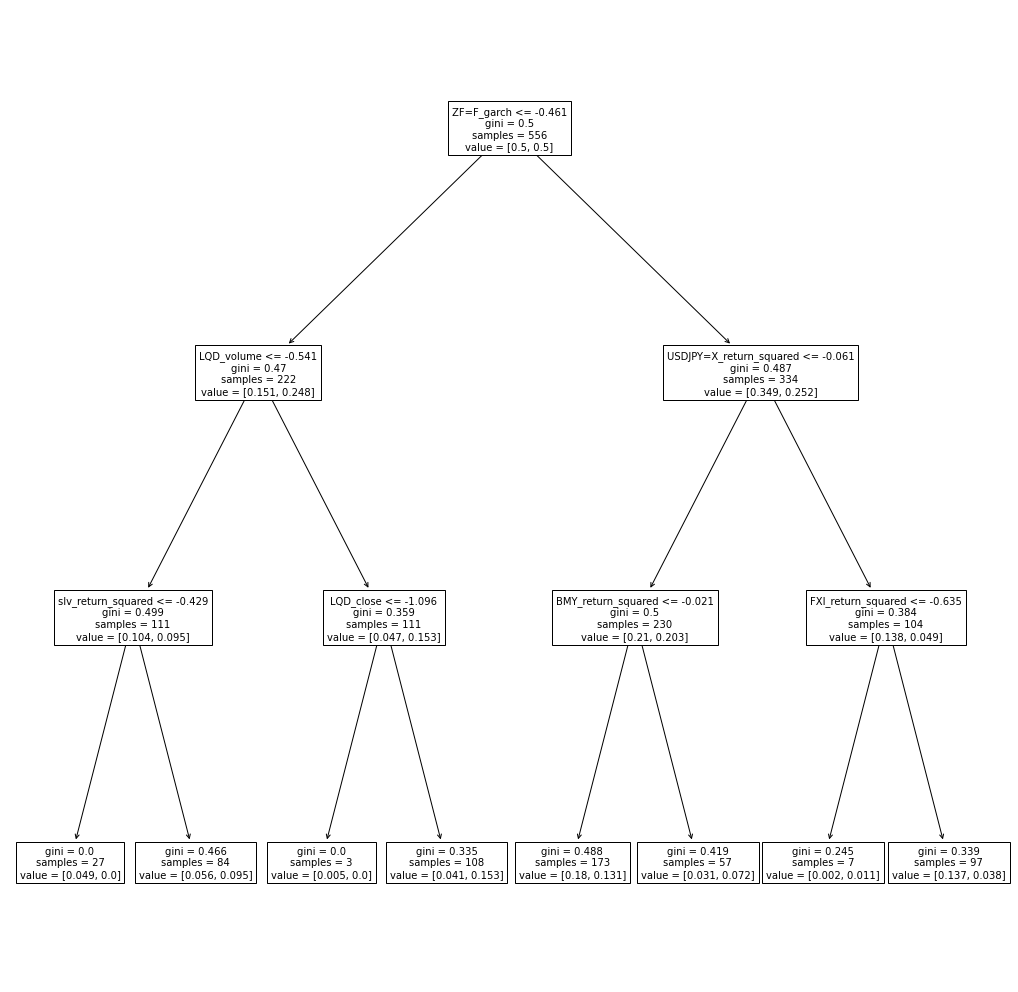

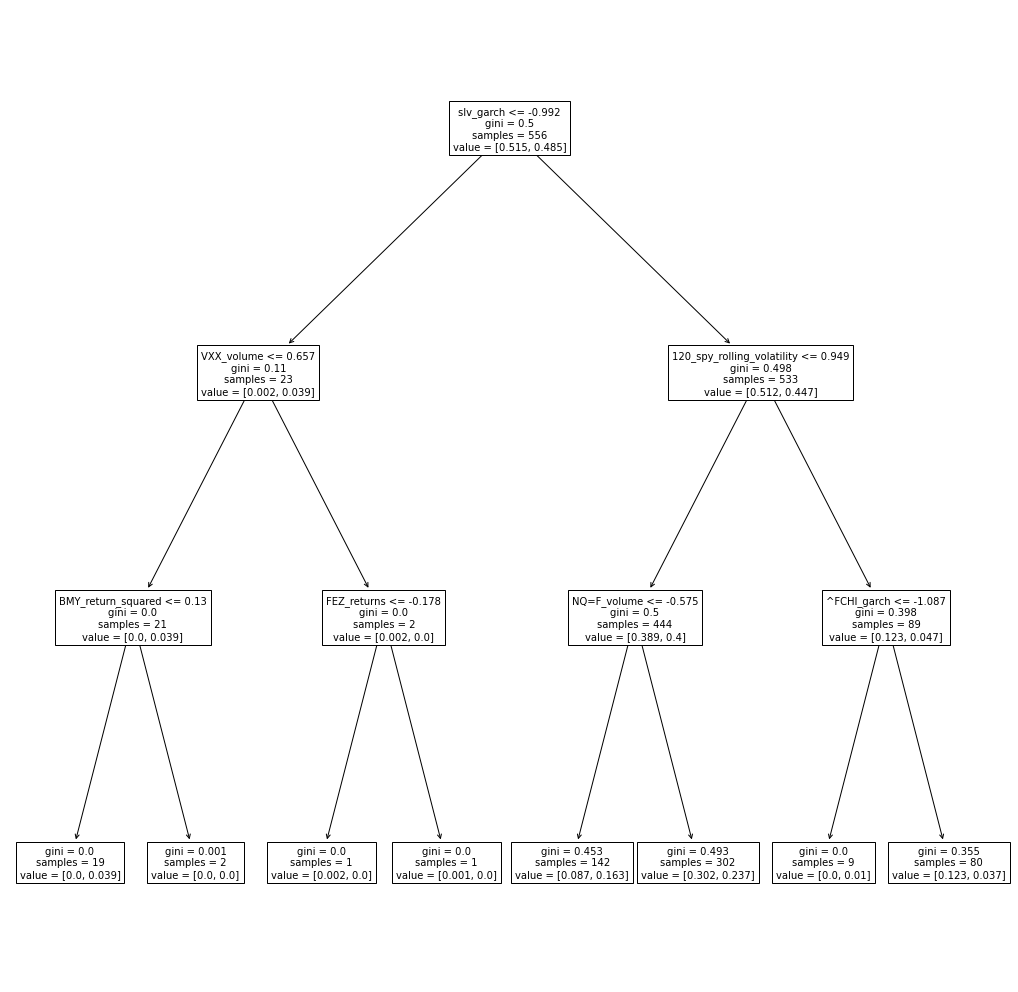

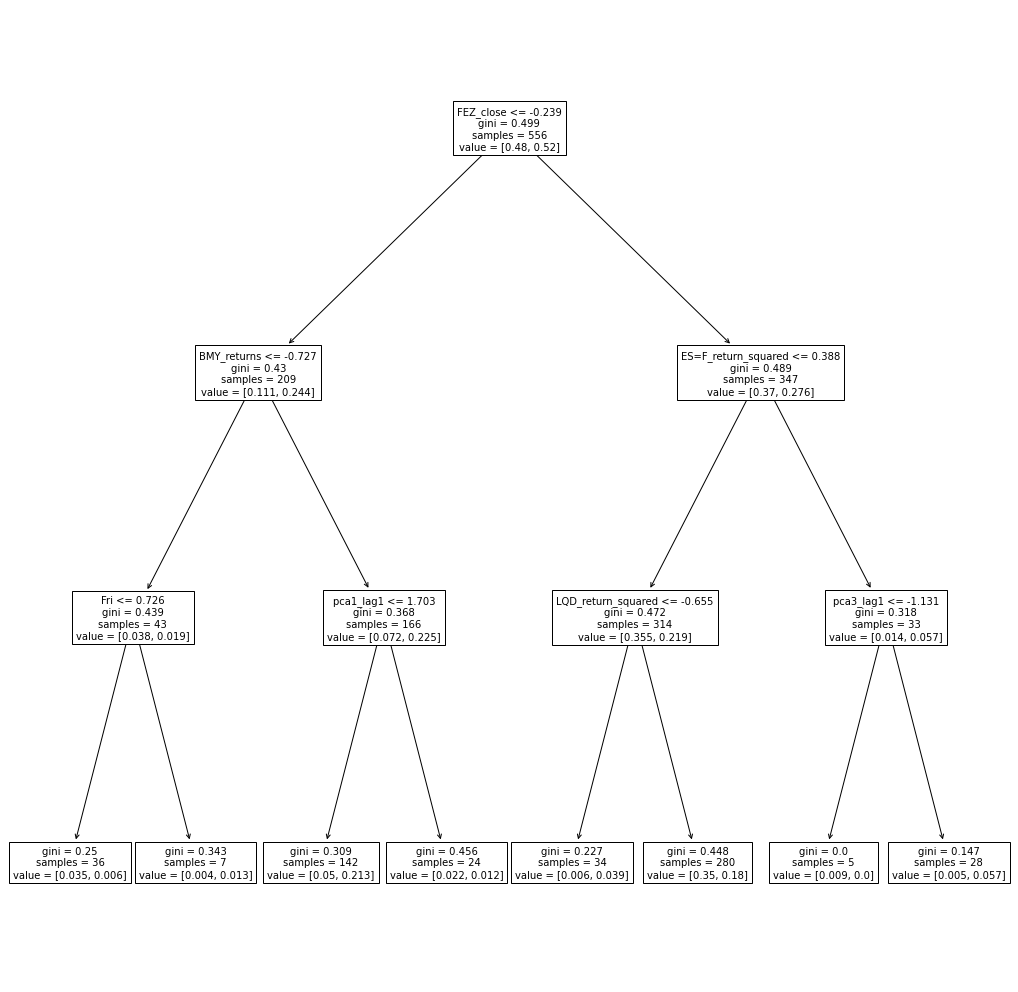

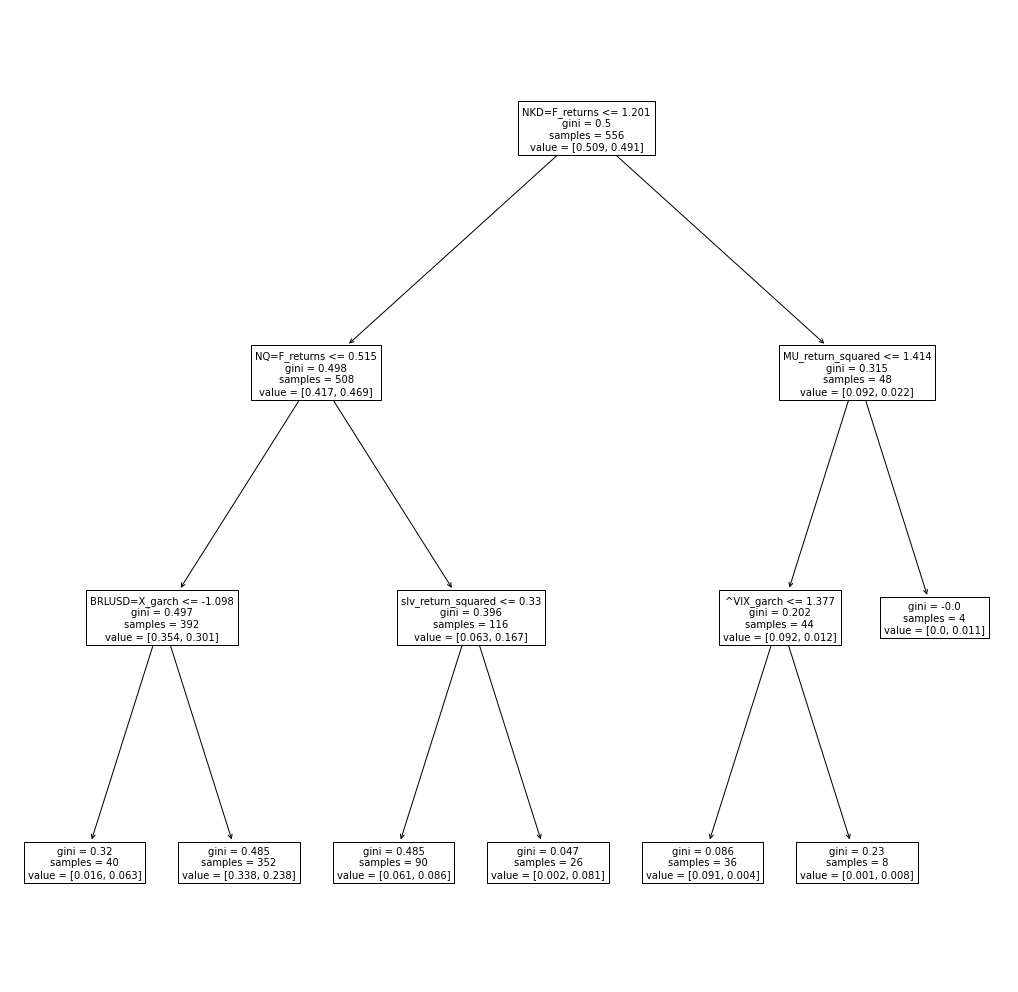

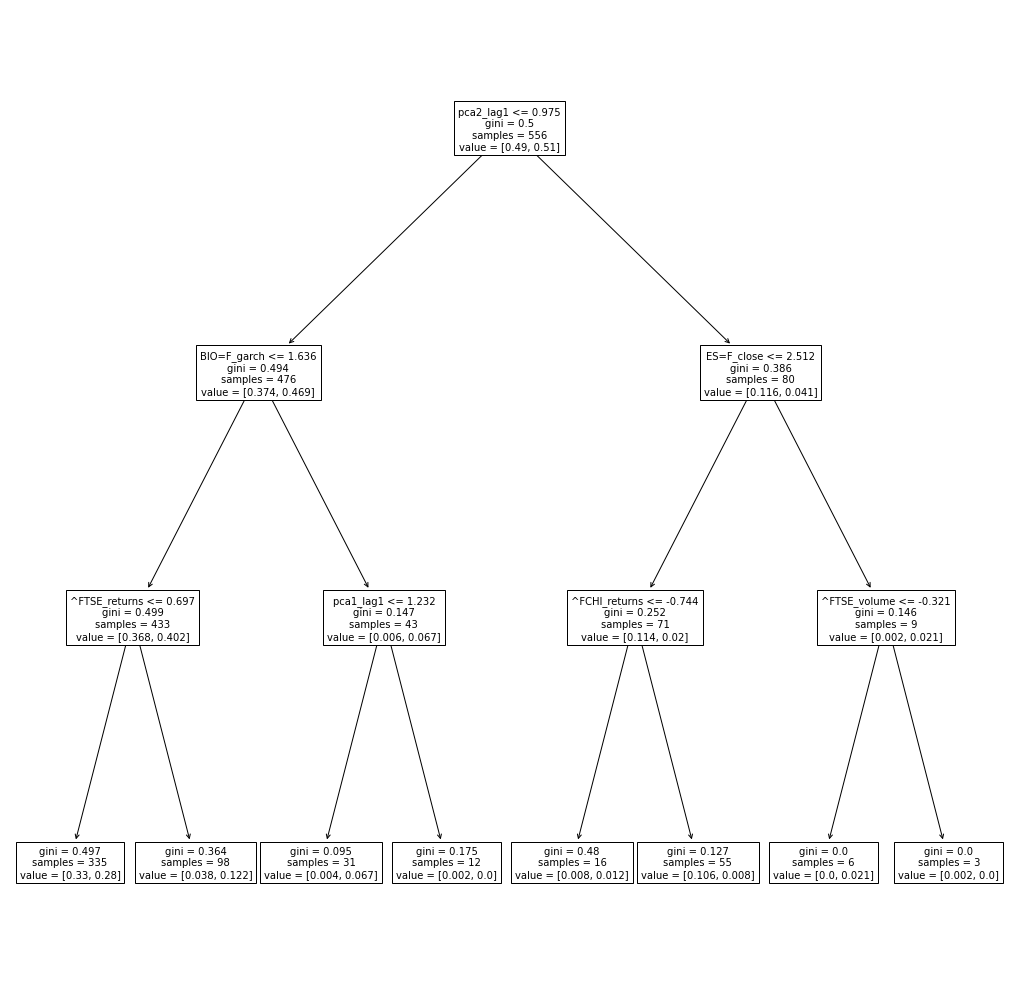

In [199]:
from sklearn import tree
#adaboost_model.estimators_
#tree.plot_tree(adaboost_model.estimators_[0],fontsize=10)

import matplotlib.pyplot as plt
# plot tree

for i in range(0,len(adaboost_model.estimators_)):
    plt.figure(figsize=(18,18))  # set plot size (denoted in inches)
    tree.plot_tree(adaboost_model.estimators_[i],fontsize=10, feature_names=X.columns, proportion=False)
    plt.show()

# Profitability Analysis
The large size of VIX returns would make a huge compounding effect if it were possible to bet on it and track its performance,.
As can be seen below, the average size of daily returns are around 5%, with returns that can get as large as 115% in one day. The median is 

In this section we will compare the results of betting on the model applying an imaginary strategy of betting at the open of the day, and close the bet at the end of the day. We will assume that the approximately the open level will be very similar than the close level of the previous day.

In [200]:
# VIX size of returns (in absolute value and %)
vixm_return_statistics=abs(100 * security_returns_df['VIXM']).describe()
display(vixm_return_statistics)

count    995.000000
mean       3.272703
std        3.653427
min        0.000000
25%        0.983278
50%        2.298075
75%        4.300288
max       37.060181
Name: VIXM, dtype: float64

In [201]:

#y_train_df.index.min()
#y_train_df.index.max()

### In-sample analysis: Return on $1 invested on training data window

In [202]:
# Results comnparison

# Profitability on the train window
fit_train= adaboost_model.predict(X_train_scaled)
fit_train_df= pd.DataFrame(fit_train, index=X_train.index)

fit_train_df.hvplot()

y_train_df=pd.DataFrame(y_train, index=X_train.index)
y_train_df

vixm_returns_train_df=vixm_ret.loc[y_train_df.index.min():y_train_df.index.max()]
vixm_returns_train_df = vixm_returns_train_df.loc[y_train_df.index]


results_train_df=pd.concat([vixm_returns_train_df, y_train_df, fit_train_df], axis=1)

results_train_df.columns=['VIXM Return', 'Correct Signal', 'Fit Signal']

predicted_return=results_train_df['VIXM Return']*results_train_df['Fit Signal']
max_return=results_train_df['VIXM Return']*results_train_df['Correct Signal']


results_train_df=pd.concat([results_train_df, predicted_return, max_return], axis=1)
results_train_df.columns=['VIXM Return', 'Correct Signal', 'Predicted Signal', 'Fit Return', 'Max Return']


return_of_one_dollar_in_train_window_df=(1+results_train_df[['VIXM Return','Fit Return']]).cumprod()
return_of_one_dollar_in_train_window_df.columns=['VIXM_ROI', 'ROI Model (in sample)']

profitability_train_plot=return_of_one_dollar_in_train_window_df.hvplot(
                                             title="In-Sample Growth of $1 initial Investment in Daily Trade Strategy on VIX",
                                             ylabel="Dollars $" ,
                                             width=1000
 )

profitability_train_plot

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [203]:
y_train_df.index

DatetimeIndex(['2018-02-16', '2018-02-19', '2018-02-21', '2018-02-22',
               '2018-02-23', '2018-02-26', '2018-02-27', '2018-02-28',
               '2018-03-01', '2018-03-02',
               ...
               '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06',
               '2020-02-07', '2020-02-10', '2020-02-11', '2020-02-12',
               '2020-02-13', '2020-02-14'],
              dtype='datetime64[ns]', name='Date', length=485, freq=None)

### Out-of--sample analysis: Return on $1 invested on training data window

In [204]:
# Results comnparison

# Profitability on the test window

# Out-of-sample Predictions 
prediction_test= adaboost_model.predict(X_test_scaled)
prediction_test_df= pd.DataFrame(prediction_test, index=X_test.index)

# Out-of-sample signals (1s or 0s) based on actual returns of the VIX
y_test_df=pd.DataFrame(y_test, index=X_test.index)
y_test_df

# VIXM returns in the test window
vixm_returns_df=vixm_ret.loc[y_test_df.index.min():y_test_df.index.max()]
vixm_returns_test_df = vixm_returns_df.loc[y_test_df.index]

# Combination of VIXM Returns, signals and predictions
results_test_df = pd.concat([vixm_returns_test_df, y_test_df, prediction_test_df], axis=1)
results_test_df.columns = ['VIXM Return', 'Correct Signal', 'Predicted Signal']

# Predicted returns
predicted_return=results_test_df['VIXM Return']*results_test_df['Predicted Signal']
max_return=results_test_df['VIXM Return']*results_test_df['Correct Signal']

# SPY as benchmark
spy_out_of_sample_period_returns=security_returns_component_df['spy'].loc[y_test_df.index.min():y_test_df.index.max()]

# DataFrame with out-of-sample results for comparison
results_test_df=pd.concat([results_test_df, predicted_return, max_return, spy_out_of_sample_period_returns], axis=1)
results_test_df.columns=['VIXM Return', 'Correct Signal', 'Predicted Signal', 'Predicted Return', "Max Return", "Benchmark: SPY"]

return_of_one_dollar_in_test_window_df=(1+results_test_df[['VIXM Return', 'Predicted Return', "Benchmark: SPY"]]).cumprod()
return_of_one_dollar_in_test_window_df.columns=['VIXM Cummulative return', ' Model Cummulative Return (out of sample)', 'Benchmark: SPY']


#Plot with out of sample return on a 1 dollar investment for the VIX, and the daily bet strategy

# Set plot and style options
profitability_test_plot=return_of_one_dollar_in_test_window_df.hvplot(
                         title='Out-Of-Sample Growth of $1 initial Investment in Daily Trade Strategy on VIXM',
                         ylabel= "Dollars $",
                         width=1000,
                         color=["red","green", "blue"]
                )

profitability_test_plot





:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [205]:
prediction_test_df.hvplot(width=1200, kind='bar')*(5*vixm_returns_df).hvplot(kind='bar', color=["green"])

:Overlay
   .Bars.I  :Bars   [Date]   (0)
   .Bars.II :Bars   [Date]   (VIXM_ret)

### Comments
0. The VIXM invest in VIX Futures in order to make profit.
1. The VIXM has massive positive returns in moments of crushes in the market, and tends to decay in time due to the rolling effect on its futures contracts. 
2. Due to the decay effect, VIXM can only be profitable for short term trades. Can not be a invest and hold strategy
3. Our algorithmic trading investment strategy on VIXM takes advantage of the good return in market crushes, and in addition allows to generate profit during bull markets.
4. The VIXCoin investment works like a buy and hold strategy, and offers an investment opportunity to diversify a portfolio to reduce risk.


In [206]:
# Graph with SPY as benchmark
#benchmark_spy_out_of_sample_period_df=(1+security_returns_component_df['spy'].loc[y_test_df.index.min():y_test_df.index.max()]).cumprod()
#benchmark_spy_out_of_sample_period_df.hvplot()

In [207]:
# Results in prediction of daily returns
min_return=threshold
results_test_for_plot_df=results_test_df[abs(results_test_df['VIXM Return'])>min_return]*100

results_test_for_plot_df.hvplot(
                    y=['VIXM Return', 'Predicted Return'],
                    title= "Out-of-sample predictions of VIXM return",
                    width=1000,
                    ylabel='Daily Return (%)'
)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [208]:
#Histogram of returns out of sample
results_test_for_plot_df.hvplot.hist(
    ['VIXM Return','Predicted Return'],
     title= "Out-of-sample VIXM returns predictions"
)

:NdOverlay   [Element]
   :Histogram   [Predicted Return]   (Predicted Return_count)

### Analysis of good and bad predictions

In [209]:
# Analysis of the good and bad out-of-sample predictions
good_predictions=results_test_df[results_test_df['Correct Signal']==results_test_df['Predicted Signal']]

bad_predictions=results_test_df[results_test_df['Correct Signal']!=results_test_df['Predicted Signal']]


In [210]:
good=good_predictions.hvplot.hist(
    ['VIXM Return','Predicted Return'],
     title= "Out-of-sample VIX Returns of Good Predictions"
)

bad=bad_predictions.hvplot.hist(
    ['VIXM Return','Predicted Return'],
     title= "Out-of-sample VIX Returns on Bad Predictions"
)
good+bad

:Layout
   .NdOverlay.I  :NdOverlay   [Element]
      :Histogram   [Predicted Return]   (Predicted Return_count)
   .NdOverlay.II :NdOverlay   [Element]
      :Histogram   [Predicted Return]   (Predicted Return_count)

### Observations
We see that the number of negative returns that are dismissed are similar to the ones avoided when returns are small. However, for large tailed negative returns, there are significantly many more that are avoided (9+6 =15) than the ones that are not avoided (3+1 = 4 )

In [211]:
# Good prediction statistics
good_predictions[['VIXM Return', 'Predicted Return']].describe()

,VIXM Return,Predicted Return
count,251.000000,251.000000
mean,-0.009269,0.014384
std,0.056376,0.041737
min,-0.155574,-0.025339
25%,-0.039902,0.000000
50%,-0.018519,-0.000000
75%,0.011746,0.011352
max,0.370602,0.370602


In [212]:
# Bad prediction statistics
bad_predictions[['VIXM Return', 'Predicted Return']].describe()

,VIXM Return,Predicted Return
count,183.000000,183.000000
mean,0.011795,-0.011522
std,0.053151,0.018467
min,-0.117600,-0.117600
25%,-0.019952,-0.019015
50%,-0.000820,0.000000
75%,0.030539,0.000000
max,0.239437,0.000000


In [213]:
# Box Plot predictions for good and bad predictions
good_pred=good_predictions['Predicted Return']
bad_pred =bad_predictions['Predicted Return']

predictions_comparison_df=pd.concat([good_predictions['Predicted Return'],bad_predictions['Predicted Return']], axis=1, ignore_index=True )*100
predictions_comparison_df.hvplot(kind='box',
                                height=800,
                                ylabel='Return (%)',
                                #clabel=['Good Predictions', 'Bad Predictions'],
                                cmap=['blue','red'],
                                title="Out-of-sample Good and Bad Returns Resulting from Model Predictions Box Plots")





#df = pd.DataFrame(np.random.randn(20), columns=['Value'])
#df['Source'] = ['Preds'] *10 +['Real'] * 10
#df['Item'] = ['item1'] *5 + ['item2']*5 + ['item1'] *5 + ['item2']*5
#df.hvplot.box(y='Value', by=['Item', 'Source'])

:BoxWhisker   [Variable]   (value)

# OUTPUTS FOR TUNNING

In [214]:
def prepare_features(XY, pca_components):
    XY_modified = XY.shift().dropna()
    y = XY_modified["Signal"].shift(-1)
    X = XY_modified
    pca = PCA(n_components = pca_components)
    principal_components = pca.fit_transform(X)
    
    pca_column_list = []
    for i in range(1, pca_components+1):
        pca_column_list.append(f"pca{i}")

    principal_components_train_test_df = pd.DataFrame(data = principal_components, columns = pca_column_list, index = XY_modified.index)
    X_pca_lag1 = create_pca_lag1(principal_components_train_test_df)
    X_pca_lag2 = create_pca_lag2(principal_components_train_test_df)
    X_pca_lag3 = create_pca_lag3(principal_components_train_test_df)
    X_pca_lag4 = create_pca_lag4(principal_components_train_test_df)
    X_pca_lag5 = create_pca_lag5(principal_components_train_test_df)
        
    X_pc_lags = concatenate_lags(X_pca_lag1, X_pca_lag2, X_pca_lag3, X_pca_lag4, X_pca_lag5)
    X_pc = concatenate_pca_with_lags(principal_components_train_test_df, X_pc_lags)
    X, y = eliminate_nans_in_pca_data(X_pc, y)
    
    X_train, y_train, X_test, y_test = split_training_test_data(X, y)
    X_train_resampled, y_train_resampled = random_over_sample(X_train, y_train)
    X_train_scaled, X_test_scaled = standard_scale(X_train_resampled, X_test)
    #principal_components_train_test
    if parameter_tuning_mode == True:
        display(sum(pca.explained_variance_ratio_))
        display(principal_components_train_test_df.shape)
    return X_train_scaled, X_test_scaled, y_train_resampled, y_test

In [82]:
if run_multiple_tuning_iterations == True: 
    for num_estimators in range (1,25, 1):
        for depth in range(1,5,1):
            for rate in range(1,20,2):
                #rate=10
                base = DecisionTreeClassifier(max_depth=depth)
                adaboost_model=AdaBoostClassifier(base_estimator=base, 
                                      n_estimators=num_estimators, 
                                      learning_rate= rate/10 )

                # Fit the model 
                adaboost_model = adaboost_model.fit(X_train_resampled, y_train_resampled)
                pred_adaboost= adaboost_model.predict(X_test_scaled)
                prediction_test_df= pd.DataFrame(pred_adaboost, index=X_test.index)
                
                #Calculate Peofitability
                # VIXM returns in the test window
                vixm_returns_df=vixm_ret.loc[y_test_df.index.min():y_test_df.index.max()]
                vixm_returns_test_df = vixm_returns_df.loc[y_test_df.index]

                # Combination of VIXM Returns, signals and predictions
                results_test_df=pd.concat([vixm_returns_test_df, y_test_df, prediction_test_df], axis=1)
                results_test_df.columns=['VIXM Return', 'Correct Signal', 'Predicted Signal']

                # Predicted returns (we don't use the correct signal, but the predicted signal)
                predicted_return_df=results_test_df['VIXM Return']*results_test_df['Predicted Signal']
                predicted_return_df.columns=['Date','VIXM_Strategy_return']
                roi_strategy_factor = (1+predicted_return_df).cumprod()[-1]
                             
        
                # Use a classification report to evaluate the model using the predictions and testing data
                adaboost_report=classification_report(y_test, pred_adaboost)

                #if num_estimators % 10 == 0 and num_components == 88:
                #    print(f"components {num_components} esimators {num_estimators}")
                #    print(f"f1 score 0 {f1_score(y_test, pred_adaboost, pos_label=0)} f1 score 1 {f1_score(y_test, pred_adaboost, pos_label=1)}")
                #    print(f"accuracy {accuracy_score(y_test, pred_adaboost)}")
                #    print(adaboost_report)
                f1_score_1 = f1_score(y_test, pred_adaboost, pos_label=1)
                f1_score_0 = f1_score(y_test, pred_adaboost, pos_label=0)
                recall_score_1 = recall_score(y_test, pred_adaboost, pos_label=1)
                recall_score_0 = recall_score(y_test, pred_adaboost, pos_label=0)
                accuracy_score_model = accuracy_score(y_test, pred_adaboost)
                if  accuracy_score_model >= .40 and f1_score_1 >= .40 and f1_score_0 >= .40 and recall_score_1 >= .40 and recall_score_0 >= .40 and roi_strategy_factor>1 :
                    print(f"estimators {num_estimators}, max tree deph: {depth},learning_rate:{rate/10}, growth of one dollar investment:{roi_strategy_factor}")
                    # print(f"variance explained {sum(pca.explained_variance_ratio_)}")
                    # Print the classification report
                    print("         AdaBoost Classification Report")
                    print(adaboost_report)
                print(f"Trying deph {depth}, n_estimators {num_estimators}, learning rate {rate/10}")

Trying deph 1, n_estimators 1, learning rate 0.1
Trying deph 1, n_estimators 1, learning rate 0.3
Trying deph 1, n_estimators 1, learning rate 0.5
Trying deph 1, n_estimators 1, learning rate 0.7
Trying deph 1, n_estimators 1, learning rate 0.9
Trying deph 1, n_estimators 1, learning rate 1.1
Trying deph 1, n_estimators 1, learning rate 1.3
Trying deph 1, n_estimators 1, learning rate 1.5
Trying deph 1, n_estimators 1, learning rate 1.7
Trying deph 1, n_estimators 1, learning rate 1.9
Trying deph 2, n_estimators 1, learning rate 0.1
Trying deph 2, n_estimators 1, learning rate 0.3
Trying deph 2, n_estimators 1, learning rate 0.5
Trying deph 2, n_estimators 1, learning rate 0.7
Trying deph 2, n_estimators 1, learning rate 0.9
Trying deph 2, n_estimators 1, learning rate 1.1
Trying deph 2, n_estimators 1, learning rate 1.3
Trying deph 2, n_estimators 1, learning rate 1.5
Trying deph 2, n_estimators 1, learning rate 1.7
Trying deph 2, n_estimators 1, learning rate 1.9
Trying deph 3, n_est

In [ ]:
# Number of estimators? 
if run_multiple_tuning_iterations == True:
    for n in range (30,200, 5):
        # Instance AdaBoost
        # Initiate the model instance
        adaboost_model=AdaBoostClassifier(n_estimators=n)

        # Fit the model 
        adaboost_model =adaboost_model.fit(X_train_scaled, y_train)
        pred_adaboost=adaboost_model.predict(X_test_scaled)
        print (n)
        # Use a classification report to evaluate the model using the predictions and testing data
        adaboost_report=classification_report(y_test, pred_adaboost)

        # Print the classification report
        print("         AdaBoost Classification Report")
        print(adaboost_report)
#120 highest 1-recall
#150 good overall accuracy, but lower 1-recall


#### Future enhancements:

* Clear variables that are not important
* Try increasing the deph of the AdaBoost model
* Include more features
* X8: use a function to generate the rolling volatilities, and set the number on the column name